In [1]:
from FedCVL import FedCVTClient, FedCVTServer

Server waiting for 2 clients...
Connected to ('127.0.0.1', 50226)
Connected to ('127.0.0.1', 47092)

[Server] Round 1/5
[Server] Batch 1/25, Loss = 83.9516
[Server] Batch 2/25, Loss = 70.8953
[Server] Batch 3/25, Loss = 72.4621
[Server] Batch 4/25, Loss = 86.9085
[Server] Batch 5/25, Loss = 69.5937
[Server] Batch 6/25, Loss = 86.9258
[Server] Batch 7/25, Loss = 87.7623
[Server] Batch 8/25, Loss = 109.5365
[Server] Batch 9/25, Loss = 85.7165
[Server] Batch 10/25, Loss = 78.7168
[Server] Batch 11/25, Loss = 86.1878
[Server] Batch 12/25, Loss = 78.6273
[Server] Batch 13/25, Loss = 92.9955
[Server] Batch 14/25, Loss = 90.3995
[Server] Batch 15/25, Loss = 72.7557
[Server] Batch 16/25, Loss = 68.9266
[Server] Batch 17/25, Loss = 86.3081
[Server] Batch 18/25, Loss = 77.6803
[Server] Batch 19/25, Loss = 71.3260
[Server] Batch 20/25, Loss = 79.5135
[Server] Batch 21/25, Loss = 80.0353
[Server] Batch 22/25, Loss = 72.4845
[Server] Batch 23/25, Loss = 69.3230
[Server] Batch 24/25, Loss = 74.0672


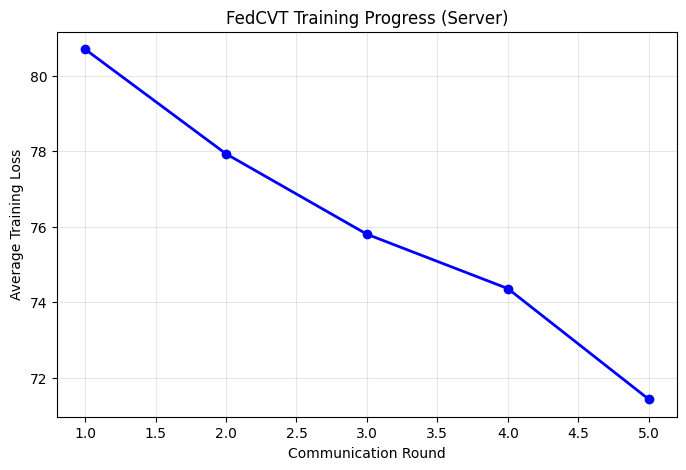

In [2]:
# ====================== SERVER NODE ======================
import socket, pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


HOST, PORT = "localhost", 9000

# Load labels
labels = pd.read_csv("../data/labels.csv").values.flatten()

# Train/test split
indices = np.arange(len(labels))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
labels_train, labels_test = labels[train_idx], labels[test_idx]
labels_train_tensor = torch.FloatTensor(labels_train)
labels_test_tensor = torch.FloatTensor(labels_test)

# Initialize server
server = FedCVTServer(encoding_dim=16)

# Start server socket
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.bind((HOST, PORT))
s.listen(2)
print("Server waiting for 2 clients...")

# Accept HVAC + Solar
clients = []
for _ in range(2):
    conn, addr = s.accept()
    print(f"Connected to {addr}")
    clients.append(conn)

# --- Multi-round training ---
num_rounds = 5
batch_size = 32
dataset_size = len(labels_train)
num_batches = (dataset_size + batch_size - 1) // batch_size

round_losses = []

for round_num in range(num_rounds):
    print(f"\n[Server] Round {round_num+1}/{num_rounds}")
    batch_losses = []

    for batch_idx in range(num_batches):
        start, end = batch_idx * batch_size, min((batch_idx+1) * batch_size, dataset_size)
        batch_labels = labels_train_tensor[start:end]

        # Receive masked encodings from both clients
        data_from_clients = []
        for conn in clients:
            data = pickle.loads(conn.recv(65536))
            data_from_clients.append(torch.tensor(data, dtype=torch.float32))

        # Train step
        loss = server.train_step(data_from_clients[0], data_from_clients[1], batch_labels)
        batch_losses.append(loss)
        print(f"[Server] Batch {batch_idx+1}/{num_batches}, Loss = {loss:.4f}")

        # Compute gradients
        grads = server.compute_client_gradients(
            data_from_clients[0], data_from_clients[1], batch_labels
        )

        # Send gradients
        for conn, grad in zip(clients, grads):
            conn.send(pickle.dumps(grad.numpy()))

    round_avg_loss = np.mean(batch_losses)
    round_losses.append(round_avg_loss)
    print(f"[Server] Round {round_num+1} avg loss = {round_avg_loss:.4f}")

print("\n[Server] Training finished.")

# --- Evaluation phase ---
print("\n[Server] Requesting test encodings for evaluation...")
for conn in clients:
    conn.send(pickle.dumps("SEND_TEST"))

# Receive test encodings
z_test = []
for conn in clients:
    data = pickle.loads(conn.recv(65536))
    z_test.append(torch.tensor(data, dtype=torch.float32))

# Predict
server.classifier.eval()
with torch.no_grad():
    preds = server.classifier(z_test[0], z_test[1]).squeeze().numpy()

labels_test_array = labels_test_tensor.numpy()
mse = np.mean((preds - labels_test_array) ** 2)
mae = np.mean(np.abs(preds - labels_test_array))
print(f"\n[Server] Evaluation Results -> MSE: {mse:.4f}, MAE: {mae:.4f}")

print("\nSample Predictions vs Actual:")
for i in range(min(10, len(preds))):
    print(f"Pred: {preds[i]:.2f}, Actual: {labels_test_array[i]:.2f}")

# --- Plot training history ---
plt.figure(figsize=(8,5))
plt.plot(range(1, num_rounds+1), round_losses, marker="o", color="blue", linewidth=2)
plt.xlabel("Communication Round")
plt.ylabel("Average Training Loss")
plt.title("FedCVT Training Progress (Server)")
plt.grid(True, alpha=0.3)
plt.show()
